In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway, tukey_hsd

pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('races.csv')
df = df[df.team1.str.startswith('Wild')]
df = df.dropna(subset=['course_color'])
print(df.shape)
df.head(2)

(1055, 21)


,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2020-01-01 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,Dixie,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice) 2023. április 22-23.,blue
1,1,2020-01-01 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice) 2023. április 22-23.,red


In [8]:
df_dogs = pd.read_csv('dogs.csv')
df_dogs.head()

,trainer,name,breed,sex,neutered,birth,ulna_length,jump_height
0,TM800418,Dexter,Kooikerhondje,M,Y,2010-02-14,14.05,25.0
1,NP950613,Jasper,Border Collie,M,Y,2011-03-28,16.56,30.0
2,UF830429,Angie,Border Collie,F,Y,2014-02-06,15.22,27.5
3,ZE801127,Alex,Border Collie,M,Y,2014-04-22,17.95,32.5
4,DP910919,Ashley,Border Collie,F,Y,2015-01-26,18.30,32.5


In [15]:
df_run1 = df[['team1', 'name1', 'name2', 'time2']]
df_run2 = df[['team1', 'name2', 'name3', 'time3']]
df_run3 = df[['team1', 'name3', 'name4', 'time4']]

col_names = ['team', 'prev_dog', 'curr_dog', 'time']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names

df_runs = pd.concat([df_run1, df_run2, df_run3])
df_runs = df_runs.dropna(subset=['time'])

df_runs = df_runs.merge(df_dogs, left_on='prev_dog', right_on='name')[['team', 'prev_dog', 'curr_dog', 'time', 'sex', 'neutered']]
df_runs.columns = ['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered']

df_runs = df_runs.merge(df_dogs, left_on='curr_dog', right_on='name')[['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered', 'sex', 'neutered']]
df_runs.columns = ['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered', 'curr_sex', 'curr_neutered']

print(df_runs.shape)
df_runs.head(5)

(3100, 8)


,team,prev_dog,curr_dog,time,prev_sex,prev_neutered,curr_sex,curr_neutered
0,WildRunners dreamers,Sunny,Dixie,4.24,F,Y,M,Y
1,WildRunners Maximini,Brooke,Rocky,5.15,M,N,M,Y
2,WildRunners dreamers,Sunny,Dixie,4.23,F,Y,M,Y
3,WildRunners Maximini,Brooke,Rocky,5.50,M,N,M,Y
4,WildRunners dreamers,Sunny,Dixie,4.29,F,Y,M,Y


Interesting. Seems that dogs run faster in avereage, if running against a non-neutered female dog. Let's perform an ANOVA test to check if this difference is significant.

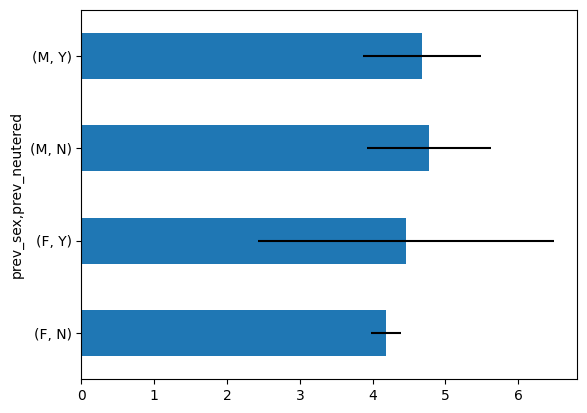

In [23]:
df_runs.groupby(['prev_sex', 'prev_neutered'])['time'].mean().plot(kind='barh', xerr=df_runs.groupby(['prev_sex', 'prev_neutered'])['time'].std());

Very little p-value indicates, that indeed, there is a significant difference of at least one of the four groups

By checking the results between each pair it turns out:
- Changing against a female dog leads to significantly better running time vs changing against a male dog (in any combinations of neuter status)
- Changing against a non-neutered female is also significantly better vs changing against a neutered female

ANOVA overall p-value: 3.109337708166901e-08




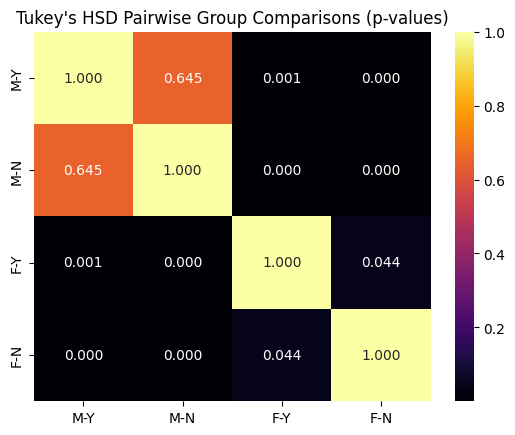

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

df_runs.groupby(['prev_sex', 'prev_neutered'])['time'].mean().plot(kind='barh', xerr=df_runs.groupby(['prev_sex', 'prev_neutered'])['time'].std(), ax=axs[0])
axs[0].set_xlabel('Average Running Time [s]')

g1 = df_runs[(df_runs.prev_sex == 'M') & (df_runs.prev_neutered == 'Y')]['time']
g2 = df_runs[(df_runs.prev_sex == 'M') & (df_runs.prev_neutered == 'N')]['time']
g3 = df_runs[(df_runs.prev_sex == 'F') & (df_runs.prev_neutered == 'Y')]['time']
g4 = df_runs[(df_runs.prev_sex == 'F') & (df_runs.prev_neutered == 'N')]['time']

data = [g1, g2, g3, g4]
_, p_value = f_oneway(*data)

print("ANOVA overall p-value:", p_value)
print("\n")

tukey_results = tukey_hsd(*data)
p_values = tukey_results.pvalue
p_values_2d = np.array(p_values).reshape(4, 4)

labels = ['M-Y', 'M-N', 'F-Y', 'F-N']
sns.heatmap(p_values_2d, annot=True, cmap='inferno', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axs[1])
plt.title('Tukey\'s HSD Pairwise Group Comparisons (p-values)')
plt.show()


In [56]:
print(tukey_results)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.093     0.645    -0.297     0.111
 (0 - 2)      0.217     0.001     0.065     0.368
 (0 - 3)      0.497     0.000     0.218     0.776
 (1 - 0)      0.093     0.645    -0.111     0.297
 (1 - 2)      0.309     0.000     0.110     0.509
 (1 - 3)      0.590     0.000     0.283     0.897
 (2 - 0)     -0.217     0.001    -0.368    -0.065
 (2 - 1)     -0.309     0.000    -0.509    -0.110
 (2 - 3)      0.281     0.044     0.005     0.556
 (3 - 0)     -0.497     0.000    -0.776    -0.218
 (3 - 1)     -0.590     0.000    -0.897    -0.283
 (3 - 2)     -0.281     0.044    -0.556    -0.005

